In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
# %matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

from plotting import *
# plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm
import shlex as shlex

In [2]:

# from rbfNet import *
# from tqdm.notebook import trange, tqdm

parser = argparse.ArgumentParser()
parser.add_argument('-e','--epochs', type=int, default=25)
parser.add_argument('-cmap','--coordinateMapping', type=str, default='preserving')
parser.add_argument('-w','--windowFunction', type=str, default='poly6')
parser.add_argument('-c','--cutoff', type=int, default=127)
parser.add_argument('-b','--batch_size', type=int, default=2)
parser.add_argument('-o','--output', type = str, default = 'trainingData')
parser.add_argument('--cutlassBatchSize', type=int, default=64)
parser.add_argument('-r','--lr', type=float, default=0.01)
parser.add_argument('--lr_decay_factor', type=float, default=0.9)
parser.add_argument('--lr_decay_step_size', type=int, default=1)
parser.add_argument('--weight_decay', type=float, default=0)
parser.add_argument('-x','--rbf_x', type=str, default='linear')
parser.add_argument('-y','--rbf_y', type=str, default='linear')
parser.add_argument('-n','--n', type=int, default=4)
parser.add_argument('-m','--m', type=int, default=4)
parser.add_argument('--seed', type=int, default=42)
parser.add_argument('--networkseed', type=int, default=42)
parser.add_argument('-d','--frameDistance', type=int, default=1)
parser.add_argument('--dataDistance', type=int, default=1)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--gpus', type=int, default=1)
parser.add_argument('-f','--forwardLoss', type=bool, default=False)
parser.add_argument('-v','--verbose', type=bool, default=False)
parser.add_argument('-l','--li', type=bool, default=True)
parser.add_argument('-a','--activation', type=str, default='relu')
parser.add_argument('--arch', type=str, default='32 64 64 3')
parser.add_argument('--limitData', type=int, default=-1)
parser.add_argument('--iterations', type=int, default=1000)
parser.add_argument('-u', '--maxUnroll', type=int, default=10)
parser.add_argument('--minUnroll', type=int, default=2)
parser.add_argument('-augj', '--augmentJitter', type=bool, default=True)
parser.add_argument('-j', '--jitterAmount', type=float, default=0.01)
parser.add_argument('-augr', '--augmentAngle', type=bool, default=False)
parser.add_argument('-adjust', '--adjustForFrameDistance', type = bool, default = False)
parser.add_argument('-netArch', '--network', type=str, default='default')
parser.add_argument('-norm', '--normalized', type=bool, default=False)

args = parser.parse_args(shlex.split("--frameDistance 1 -n 4 -m 4 --arch '32 64 64 3' -x 'fourier' -y 'fourier' -w None -cmap cartesian --epochs 25 --networkseed 209652396 -netArch default --output paperData_collision"))
args = parser.parse_args(shlex.split("--frameDistance 1 -n 4 -m 4 --arch '32 64 64 3' -x 'linear' -y 'linear' -w None -cmap cartesian --epochs 25 --networkseed 209652396 -netArch default --output paperData_collision"))


In [3]:

if args.verbose:
    print('Setting all rng seeds to %d' % args.seed)
import random 
import numpy as np

random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

if args.verbose:
    print('Available cuda devices:', torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if args.verbose:
    print('Running on Device %s' % device)
torch.set_num_threads(1)

# from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from datautils import *
from plotting import *

# Use dark theme
# plt.style.use('dark_background')
from tqdm import tqdm
import os

from rbfNet import *


if args.verbose:
    print('Parsing data in ../export')
basePath = '../export'
basePath = os.path.expanduser('~/dev/datasets/generativeCollisions')
basePath = os.path.expanduser('/mnt/data/datasets/generativeCollisions')

trainingFiles = [basePath + '/train/' + f for f in os.listdir(basePath + '/train/') if f.endswith('.hdf5')]
testingFiles = [basePath + '/testing/' + f for f in os.listdir(basePath + '/testing/') if f.endswith('.hdf5')]

training = []
validation = []
testing = []

    
    # for s in simulationFiles:    
#     _, train, valid, test = splitFileZSTD(s, split = True, limitRollOut = False, skip = 0, cutoff = 1800, distance = 1)
#     training.append((s,train))
#     validation.append((s,valid))
#     testing.append((s,test))
# debugPrint(training)

# simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]

if args.limitData > 0:
    files = []
    for i in range(max(len(trainingFiles), args.limitData)):
        files.append(trainingFiles[i])
    simulationFiles = files
# simulationFiles = [simulationFiles[0]]
if args.verbose:
    print('Input files:')
    for i, c in enumerate(trainingFiles):
        print('\t', i ,c)

training = []
validation = []
testing = []

for s in trainingFiles:
    f, s, u = splitFile(s, split = False, cutoff = -args.frameDistance * args.maxUnroll - 1, skip = args.frameDistance if args.adjustForFrameDistance else 10)
    training.append((f, (s,u)))
for s in testingFiles:
    f, s, u = splitFile(s, split = False, cutoff = -args.frameDistance * args.maxUnroll - 1, skip = args.frameDistance if args.adjustForFrameDistance else 10)
    testing.append((f, (s,u)))

In [4]:
options_z = np.random.randint(0, 2**30, 8)
print(options_z)

[534895718 199900595 862061404 787846414 996406378 127521863 423734972
 415968276]


In [5]:
def buildCommand(n, rbf, window, augmentAngle, augmentJitter, overfit):
    return f"clear && python ./collisionLayoutAblation.py --networkseeds='358250407 230424387 990342895 762624505 775156975 921029111 865301193 919098566' --widths='1 2 4 8 16 32 64' --depths='1 2 3 4 5 6 7 8 16 32' -n={n} -m={n} -x={rbf} -y={rbf} -w={window} --augmentAngle={'TRUE' if augmentAngle else 'False'} --augmentJitter={'TRUE' if augmentAngle else 'False'} --overfit=={'TRUE' if overfit else 'False'}"
print(buildCommand(4,'fourier', 'None', False, False, True))
print(buildCommand(4,'fourier', 'None', True, False, True))
print(buildCommand(6,'fourier', 'None', False, False, True))
print(buildCommand(8,'fourier', 'None', False, False, True))
print(buildCommand(5,'ffourier', 'None', False, False, True))
print(buildCommand(5,'ffourier', 'None', True, False, True))
print(buildCommand(7,'ffourier', 'None', False, False, True))
print(buildCommand(9,'ffourier', 'None', False, False, True))
print(buildCommand(4,'fourier', 'poly6', False, False, True))
print(buildCommand(4,'fourier', 'poly6', True, False, True))
print(buildCommand(6,'fourier', 'poly6', False, False, True))
print(buildCommand(8,'fourier', 'poly6', False, False, True))
print(buildCommand(5,'ffourier', 'poly6', False, False, True))
print(buildCommand(5,'ffourier', 'poly6', True, False, True))
print(buildCommand(7,'ffourier', 'poly6', False, False, True))
print(buildCommand(9,'ffourier', 'poly6', False, False, True))
print(buildCommand(4,'linear', 'poly6', False, False, True))
print(buildCommand(4,'linear', 'poly6', True, False, True))
print(buildCommand(6,'linear', 'poly6', False, False, True))
print(buildCommand(8,'linear', 'poly6', False, False, True))

clear && python ./collisionLayoutAblation.py --networkseeds='358250407 230424387 990342895 762624505 775156975 921029111 865301193 919098566' --widths='1 2 4 8 16 32 64' --depths='1 2 3 4 5 6 7 8 16 32' -n=4 -m=4 -x=fourier -y=fourier -w=None --augmentAngle=False --augmentJitter=False --overfit==TRUE
clear && python ./collisionLayoutAblation.py --networkseeds='358250407 230424387 990342895 762624505 775156975 921029111 865301193 919098566' --widths='1 2 4 8 16 32 64' --depths='1 2 3 4 5 6 7 8 16 32' -n=4 -m=4 -x=fourier -y=fourier -w=None --augmentAngle=TRUE --augmentJitter=TRUE --overfit==TRUE
clear && python ./collisionLayoutAblation.py --networkseeds='358250407 230424387 990342895 762624505 775156975 921029111 865301193 919098566' --widths='1 2 4 8 16 32 64' --depths='1 2 3 4 5 6 7 8 16 32' -n=6 -m=6 -x=fourier -y=fourier -w=None --augmentAngle=False --augmentJitter=False --overfit==TRUE
clear && python ./collisionLayoutAblation.py --networkseeds='358250407 230424387 990342895 76262

In [6]:
print(testingFiles)

['/mnt/data/datasets/generativeCollisions/testing/collision - 2023-07-31_19-24-17.hdf5', '/mnt/data/datasets/generativeCollisions/testing/collision - 2023-07-31_19-34-36.hdf5', '/mnt/data/datasets/generativeCollisions/testing/collision - 2023-07-31_19-39-31.hdf5', '/mnt/data/datasets/generativeCollisions/testing/collision - 2023-07-31_19-29-28.hdf5']


In [7]:

inFile = h5py.File(trainingFiles[0], 'r')
frameCount = int(len(inFile['simulationExport'].keys()))
inFile.close()

In [8]:
train_ds = datasetLoader(training)
print(len(train_ds))
test_ds = datasetLoader(testing)
print(len(test_ds))

6656
416


In [9]:
from tqdm.notebook import tqdm

In [10]:
# data = position | velocity | gravity | features
iterator = iter(train_ds)
file, frame, r = train_ds[0]
attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)

# dataCache = torch.zeros((len(trainingFiles) * frameCount, inputData['fluidPosition'].shape[0], 12))
dataCache = {}

for file in tqdm(trainingFiles):
    data = torch.zeros((frameCount, inputData['fluidPosition'].shape[0], 12))
    for frame in tqdm(range(frameCount-1), leave = False):
        attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)
    #     fluidPositions = inputData['fluidPosition']
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    #     print(fluidFeatures.shape)
    #     fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
    #     loadBatch(train_ds, [i], constructFluidFeatures, unroll, args.frameDistance, augmentAngle = args.augmentAngle, augmentJitter = args.augmentJitter, jitterAmount = 0.0, adjustForFrameDistance = args.adjustForFrameDistance)  

        difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
        # print(difference)
        distance = torch.linalg.norm(difference,axis=1) + 1e-7
        difference = difference / distance[:, None]
        fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2
    #     print('Fluid Gravity (Computed): ', fluidGravity)

    #     cachedData = torch.zeros((fluidPositions.shape[0], fluidPositions.shape[1] + inputData['fluidVelocity'].shape[1] + fluidGravity.shape[1] + fluidFeatures.shape[1]))
        data[frame,:,0:2] = fluidPositions
        data[frame,:,2:4] = inputData['fluidVelocity']
        data[frame,:,4:6] = fluidGravity
        data[frame,:,6:10] = fluidFeatures
        data[frame,:,10:] = groundTruthData[0][:,:2]
    dataCache[file] = data
    
#     break
for file in tqdm(testingFiles):
    data = torch.zeros((frameCount, inputData['fluidPosition'].shape[0], 12))
    for frame in tqdm(range(frameCount-1), leave = False):
        attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)
    #     fluidPositions = inputData['fluidPosition']
        fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    #     print(fluidFeatures.shape)
    #     fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidGravity, fluidBatches, boundaryBatches, groundTruths, attributes = \
    #     loadBatch(train_ds, [i], constructFluidFeatures, unroll, args.frameDistance, augmentAngle = args.augmentAngle, augmentJitter = args.augmentJitter, jitterAmount = 0.0, adjustForFrameDistance = args.adjustForFrameDistance)  

        difference = fluidPositions - torch.tensor([0,0], dtype = fluidPositions.dtype, device = fluidPositions.device)
        # print(difference)
        distance = torch.linalg.norm(difference,axis=1) + 1e-7
        difference = difference / distance[:, None]
        fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2
    #     print('Fluid Gravity (Computed): ', fluidGravity)

    #     cachedData = torch.zeros((fluidPositions.shape[0], fluidPositions.shape[1] + inputData['fluidVelocity'].shape[1] + fluidGravity.shape[1] + fluidFeatures.shape[1]))
        data[frame,:,0:2] = fluidPositions
        data[frame,:,2:4] = inputData['fluidVelocity']
        data[frame,:,4:6] = fluidGravity
        data[frame,:,6:10] = fluidFeatures
        data[frame,:,10:] = groundTruthData[0][:,:2]
    dataCache[file] = data
    
#     break

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [11]:
# for s in tqdm(validationFiles):
#     f, s, u = splitFile(s, split = False, cutoff = -4, skip = 0)
#     validation.append((f, (s,u)))
    
if args.verbose:
    print('Processed data into datasets:')
    debugPrint(training)
    debugPrint(validation)
    debugPrint(testing)

batch_size = args.batch_size

if args.verbose:
    print('Setting up data loaders')
train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler


/home/winchenbach/anaconda3/envs/torch_env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


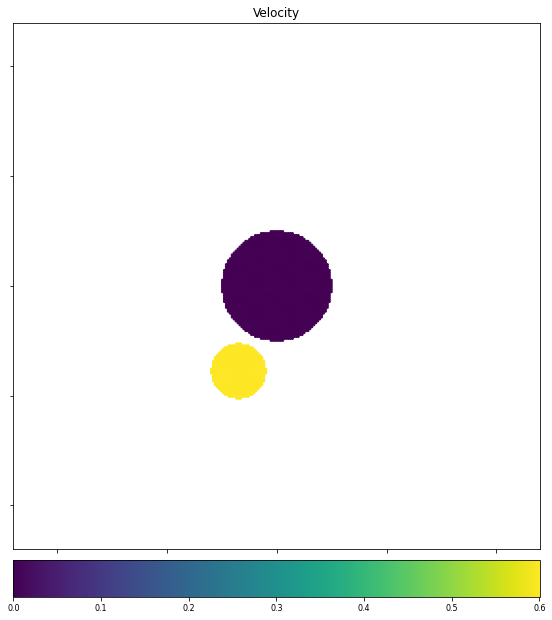

interactive(children=(Dropdown(description='file', options=('/mnt/data/datasets/generativeCollisions/train/col…

<function __main__.plotNetwork(file, frame)>

In [12]:
fig, axis = plt.subplots(1, 1, figsize=(8,8*1.09), sharex = False, sharey = False, squeeze = False)

attributes, inputData, groundTruthData = loadFrame(trainingFiles[0], 0, 1 + np.arange(1), 1)

x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

axis[0,0].set_title('Velocity')
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 4)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-1.2,1.2)
axis[0,0].set_ylim(-1.2,1.2)

axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =2 )
axis[0,0].set_xticklabels([])
axis[0,0].set_yticklabels([])
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 
fig.tight_layout()

def plotNetwork(file, frame):
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(1), 1)

    data = inputData['fluidDensity'].detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))

    axis[0,0].set_title('%s @ %2d' % (file.split('/')[-1], frame))
    fig.canvas.draw()
    fig.canvas.flush_events()
interact(plotNetwork, file = trainingFiles, frame = widgets.IntSlider(value=0, min=0, max=128 -1, step=1))

In [13]:
n = args.n
m = args.m
coordinateMapping = args.coordinateMapping
windowFn = getWindowFunction(args.windowFunction)
rbf_x = args.rbf_x
rbf_y = args.rbf_y
initialLR = args.lr
maxRollOut = 10
epochs = args.epochs
frameDistance = args.frameDistance

# if args.verbose:
print('Network Hyperparameters:')
print('[n x m]: [%dx%d]'% (n, m))
print('[rbf_x x rbf_y]: [%sx%s]'% (rbf_x, rbf_y))
print('Mapping:', args.coordinateMapping)
print('window function:', args.windowFunction)
print('activation function:', args.activation)
print('initial learning rate: ', initialLR)
print('Training for %d epochs' % epochs)
print('Rollout limit (if applicable):', maxRollOut)
print('Training with frame offset of', frameDistance)
print('Network architecture', args.arch)


widths = args.arch.strip().split(' ')
layers = [int(s) for s in widths]
# debugPrint(layers)
if args.verbose:
    print('Building Network')

Network Hyperparameters:
[n x m]: [4x4]
[rbf_x x rbf_y]: [linearxlinear]
Mapping: cartesian
window function: None
activation function: relu
initial learning rate:  0.01
Training for 25 epochs
Rollout limit (if applicable): 10
Training with frame offset of 1
Network architecture 32 64 64 3


In [14]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

random.seed(args.networkseed)
torch.manual_seed(args.networkseed)
torch.cuda.manual_seed(args.networkseed)
np.random.seed(args.networkseed)
boundaryFeatures = None

model = None
if args.network == 'default':
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'split':
    model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'interleaved':
    model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'input':
    model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'output':
    model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
model = model.to(device)
model.train()

RbfNet(
  (convs): ModuleList(
    (0): RbfConv(4, 32, dim=2)
    (1): RbfConv(64, 64, dim=2)
    (2): RbfConv(64, 64, dim=2)
    (3): RbfConv(64, 3, dim=2)
  )
  (fcs): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [15]:
hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] =  args.windowFunction
hyperParameterDict['liLoss'] = 'yes' if args.li else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['dataDistance'] = args.dataDistance
hyperParameterDict['parameters'] =  count_parameters(model)
hyperParameterDict['cutoff'] =  args.cutoff
hyperParameterDict['dataLimit'] =  args.limitData 
hyperParameterDict['arch'] =  args.arch
hyperParameterDict['seed'] =  args.seed
hyperParameterDict['minUnroll'] =  args.minUnroll
hyperParameterDict['maxUnroll'] =  args.maxUnroll
hyperParameterDict['augmentAngle'] =  args.augmentAngle
hyperParameterDict['augmentJitter'] =  args.augmentJitter
hyperParameterDict['jitterAmount'] =  args.jitterAmount
hyperParameterDict['networkSeed'] =  args.networkseed
hyperParameterDict['network'] = args.network
hyperParameterDict['normalized'] = args.normalized
hyperParameterDict['adjustForFrameDistance'] = args.adjustForFrameDistance
lr = initialLR


timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
networkPrefix = args.network

exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d arch %s distance = %2d - %s seed %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], args.windowFunction, hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], args.arch, frameDistance, timestamp, args.networkseed)

shortLabel = '%14s [%14s] - %s -> [%16s, %16s] x [%2d, %2d] @ %2s ' % (hyperParameterDict['windowFunction'], hyperParameterDict['arch'], hyperParameterDict['coordinateMapping'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['n'], hyperParameterDict['m'],hyperParameterDict['networkSeed'])
# print(shortLabel)

# exit()
# if args.gpus == 1:
print(shortLabel)

          None [    32 64 64 3] - cartesian -> [          linear,           linear] x [ 4,  4] @ 209652396 


In [16]:
# exit()
# if args.gpus == 1:

#     debugPrint(hyperParameterDict)
# if args.gpus == 1:
#     debugPrint(exportString)
if args.verbose:
    print('Writing output to ./%s/%s' % (args.output, exportString))

# exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
if not os.path.exists('./%s/%s' % (args.output, exportString)):
    os.makedirs('./%s/%s' % (args.output, exportString))
# self.outFile = h5py.File(self.exportPath,'w')


In [17]:
%matplotlib notebook

In [18]:
from tqdm.notebook import tqdm
# dataCache = dataCache.to(device)

In [19]:
attributes['support']

0.035287954

In [20]:
dataSet = train_ds
jitterAmount = 0.01
unrollSteps = 8

In [21]:
# dataRows = []
# for ib, b in enumerate(bdata):
#     file, frame, unroll = dataSet[b]
#     batchData = []
#     for iu, u in enumerate(range(unrollSteps)):
#         currRow = dataCache[file][frame + u,:].unsqueeze(0)
# #             print('Current row shape: ', currRow.shape)
#         batchData.append(currRow)
    
#     stacked = torch.vstack(batchData)
#     angle = torch.rand(1) * 2 * np.pi
#     rot = torch.tensor([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]], device = stacked.device, dtype = stacked.dtype)
    
#     stacked[0,:,0:2] += torch.normal(torch.zeros_like(stacked[0,:,0:2]), torch.ones_like(stacked[0,:,0:2]) * jitterAmount * attributes['support'])
    
#     for iu, u in enumerate(range(unrollSteps)):
#         stacked[iu,:,0:2] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,0:2].unsqueeze(2))[:,:,0] 
#         stacked[iu,:,2:4] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,2:4].unsqueeze(2))[:,:,0] 
#         stacked[iu,:,4:6] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,4:6].unsqueeze(2))[:,:,0] 
#         stacked[iu,:,7:9] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,7:9].unsqueeze(2))[:,:,0] 
#         stacked[iu,:,10:12] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,10:12].unsqueeze(2))[:,:,0] 
#     dataRows.append(stacked)
#     break
# dataRows = torch.stack(dataRows)

In [33]:
def processBatchCached(bdata, unrollSteps : int, dataCache : torch.Tensor, attributes, model, optimizer, dataSet, augmentAngle = False, augmentJitter = False, jitterAmount = 0.01, returnLoss = True):
#     pbl = gtqdms[args.gpu + args.gpus]
    dataRows = []
    for ib, b in enumerate(bdata):
        file, frame, unroll = dataSet[b]
        batchData = []
        for iu, u in enumerate(range(unrollSteps)):
            currRow = dataCache[file][frame + u,:].unsqueeze(0)
            batchData.append(currRow)

        stacked = torch.vstack(batchData)
        angle = torch.rand(1) * 2 * np.pi
        rot = torch.tensor([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]], device = stacked.device, dtype = stacked.dtype)
        if augmentJitter:
            stacked[0,:,0:2] += torch.normal(torch.zeros_like(stacked[0,:,0:2]), torch.ones_like(stacked[0,:,0:2]) * jitterAmount * attributes['support'])
        if augmentAngle:
            for iu, u in enumerate(range(unrollSteps)):
                stacked[iu,:,0:2] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,0:2].unsqueeze(2))[:,:,0] 
                stacked[iu,:,2:4] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,2:4].unsqueeze(2))[:,:,0] 
                stacked[iu,:,4:6] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,4:6].unsqueeze(2))[:,:,0] 
                stacked[iu,:,7:9] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,7:9].unsqueeze(2))[:,:,0] 
                stacked[iu,:,10:12] = torch.matmul(rot.unsqueeze(0).repeat(stacked.shape[1],1,1), stacked[iu,:,10:12].unsqueeze(2))[:,:,0] 

        dataRows.append(stacked)
    dataRows = torch.stack(dataRows)
    dataRows = dataRows.to(device)
    fluidBatches = torch.hstack([torch.ones(dataRows.shape[2]) * i for i in range(len(bdata))]).to(device)
    
    fluidPositions = torch.clone(torch.vstack([r[0,:,0:2] for r in dataRows]))
    fluidVelocity = torch.clone(torch.vstack([r[0,:,2:4] for r in dataRows]))
    fluidGravity = torch.clone(torch.vstack([r[0,:,4:6] for r in dataRows]))
    fluidFeatures = torch.vstack([r[0,:,6:10] for r in dataRows])

    boundaryPositions = None
    boundaryFeatures = None
    boundaryBatches = None

    unrollLosses = []

    optimizer.zero_grad()
    for iu, u in enumerate(range(unrollSteps)):    
        gtFluidPositions = torch.vstack([r[iu,:,10:12] for r in dataRows])

        intermediateVelocity = fluidVelocity + frameDistance * attributes['dt'] * fluidGravity
        intermediatePositions = fluidPositions + frameDistance * attributes['dt'] * intermediateVelocity

        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], intermediateVelocity, fluidFeatures[:,3:]))
        predictedUpdate = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)

        loss = torch.linalg.norm(intermediatePositions + predictedUpdate[:,:2] * attributes['dt'] - gtFluidPositions, dim = 1) / attributes['dt']
        lossTerm = torch.mean(loss.reshape(len(bdata), dataRows.shape[2]), dim = 1)
        unrollLosses.append(lossTerm)

        if iu != unrollSteps - 1:
            updatedPositions = intermediatePositions + predictedUpdate[:,:2] * attributes['dt']
            fluidVelocity = (updatedPositions - fluidPositions) / attributes['dt']
            fluidPositions = updatedPositions
            difference = fluidPositions
            distance = torch.linalg.norm(difference,axis=1) + 1e-7
            difference = difference / distance[:, None]
            fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2

    stackedLosses = torch.vstack(unrollLosses)
    overallLoss = torch.mean(stackedLosses)
    overallLoss.backward()
    optimizer.step()
    return stackedLosses.detach().cpu().numpy() if returnLoss else None

# def trainNetwork(layers, n, m, rbf_x, rbf_y, seed):
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     np.random.seed(seed)
#     boundaryFeatures = None

#     model = None
#     if args.network == 'default':
#         model = RbfNet(
#             4, boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, 
#             coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, 
#             rbf_x = rbf_x, rbf_y = rbf_y, 
#             batchSize = args.cutlassBatchSize, normalized = args.normalized)
#     if args.network == 'split':
#         model = RbfSplitNet(4, boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
#     if args.network == 'interleaved':
#         model = RbfInterleaveNet(4, boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
#     if args.network == 'input':
#         model = RbfInputNet(4, boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
#     if args.network == 'output':
#         model = RbfOutputNet(4, boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)

#     lr = initialLR
# #     optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
#     optimizer = Adam(model.parameters(), lr=initialLR, weight_decay=args.weight_decay)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
#     model = model.to(device)
#     model.train()
    
#     losses = []
#     l2 = []

#     batch = [10,20,30,40]
#     if args.overfit:
#         batch = [10]
#     unrollSteps = 1   

#     dataLoader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler
#     t = gtqdms[args.gpu + args.gpus]
#     with portalocker.Lock('README.md', flags = 0x2, timeout = None):
#         t.reset(total=iterationsPerEpoch * epochs)
#     for i in range(iterationsPerEpoch * epochs):
#         if not args.overfit:
#             try:
#                 batch = next(dataIter)
#             except:
#                 dataIter = iter(dataLoader)
#                 batch = next(dataIter)
#         batchLoss = processBatchCached(batch, unrollSteps, dataCache, attributes, model, optimizer, train_ds, args.augmentAngle, args.augmentJitter, args.jitterAmount, returnLoss = True)

#         losses.append(batchLoss)
#         l2.append(np.mean(batchLoss))

#         with portalocker.Lock('README.md', flags = 0x2, timeout = None):
#             t.set_description('[%2dx%2d]@%10d: Training it = %5d [%2d], batch: [%s] x %2d, lr: %.4e, batchLoss: %.5e, rollingLoss: %.5e ' % 
#                           (len(layers),
#                            layers[0],
#                            seed,
#                            i % iterationsPerEpoch, 
#                            i // iterationsPerEpoch,
#                            ' '.join(['%04d' % b for b in batch]), 
#                            unrollSteps,
#                            optimizer.param_groups[0]['lr'],
#                            np.mean(batchLoss), 
#                            np.mean(l2[-100:] if len(l2) > 100 else l2),
#                         #    ' '.join(['%.4e' % v for v in np.mean(batchLoss, axis = 0)])
#                           ))
#             t.update()
#             pb.update()
#         if i % lrStep == 0 and i > 0:
#             scheduler.step()
            
#     processedLosses = [np.mean(l, axis = 1).tolist() for l in losses]
#     longestUnroll = losses[-1].shape[0]
#     unrollLengths = np.arange(longestUnroll) + 1
#     filtered = []

#     for i in unrollLengths:
#         nStepLoss = [l[i - 1] for l in processedLosses if len(l) >= i]
#         filtered.append(nStepLoss)
        
        
#     return {'model' : model, 'n':n, 'm':m,'layers':layers, 'rbf_x':rbf_x, 'rbf_y':rbf_y, 'processesLosses': processedLosses, 'filtered': filtered, 'l2':l2, 'window': args.windowFunction, 'seed': seed}


In [34]:
def evalBatch(bdata, unrollSteps : int, dataCache : torch.Tensor, attributes, model, dataSet):
#     dataRows = torch.zeros([len(bdata), unrollSteps, dataCache.shape[1], dataCache.shape[2]])
    dataRows = []
    for ib, b in enumerate(bdata):
        file, frame, unroll = dataSet[b]
        batchData = []
        for iu, u in enumerate(range(unrollSteps)):
            currRow = dataCache[file][frame + u,:].unsqueeze(0)
#             print('Current row shape: ', currRow.shape)
            batchData.append(currRow)
        stacked = torch.vstack(batchData)
#         print('Stacked shape:', stacked.shape)
        dataRows.append(stacked)
    dataRows = torch.stack(dataRows)
#     print('data rows shape', dataRows.shape)
    
#     dataRows = torch.zeros([len(bdata), unrollSteps, dataCache.shape[1], dataCache.shape[2]])

#     for ib, b in enumerate(bdata):
#         for iu, u in enumerate(range(unrollSteps)):
#             currRow = dataCache[b + iu,:,:]
#             dataRows[ib, iu, :, :] = currRow
    dataRows = dataRows.to(device)
    fluidBatches = torch.hstack([torch.ones(dataRows.shape[2]) * i for i in range(len(bdata))]).to(device)
    
    fluidPositions = torch.clone(torch.vstack([r[0,:,0:2] for r in dataRows]))
    fluidVelocity = torch.clone(torch.vstack([r[0,:,2:4] for r in dataRows]))
    fluidGravity = torch.clone(torch.vstack([r[0,:,4:6] for r in dataRows]))
    fluidFeatures = torch.vstack([r[0,:,6:10] for r in dataRows])

    boundaryPositions = None
    boundaryFeatures = None
    boundaryBatches = None

    unrollLosses = []
    states = []
#     optimizer.zero_grad()
    for iu, u in enumerate(range(unrollSteps)):    
        gtFluidPositions = torch.vstack([r[iu,:,10:12] for r in dataRows])

        intermediateVelocity = fluidVelocity + frameDistance * attributes['dt'] * fluidGravity
        intermediatePositions = fluidPositions + frameDistance * attributes['dt'] * intermediateVelocity

        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], intermediateVelocity, fluidFeatures[:,3:]))
        predictedUpdate = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)
        
        
#         loss = model.li * torch.sqrt(torch.linalg.norm(intermediatePositions + predictedUpdate[:,:2] * attributes['dt'] - gtFluidPositions, dim = 1)) / attributes['dt']
        states.append((torch.clone(fluidPositions).detach().cpu(), torch.clone(fluidVelocity).detach().cpu(), torch.clone(fluidGravity).detach().cpu(), torch.clone(predictedUpdate).detach().cpu(), torch.clone(gtFluidPositions).detach().cpu(), torch.clone(loss).detach().cpu()))
        lossTerm = torch.mean(loss.reshape(len(bdata), dataRows.shape[2]), dim = 1)
#         print('loss', loss)
#         print('loss.reshaped', loss.reshape(len(bdata), dataCache.shape[1]))
#         print('lossTerm', lossTerm)
        unrollLosses.append(lossTerm)

        if iu != unrollSteps - 1:
            updatedPositions = intermediatePositions + predictedUpdate[:,:2] * attributes['dt']
            fluidVelocity = (updatedPositions - fluidPositions) / attributes['dt']
            fluidPositions = updatedPositions
            difference = fluidPositions
            distance = torch.linalg.norm(difference,axis=1) + 1e-7
            difference = difference / distance[:, None]
            fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2

#     print(unrollLosses)
#     print(torch.vstack(unrollLosses))
#     print(torch.mean(torch.vstack(unrollLosses)))
    stackedLosses = torch.vstack(unrollLosses)
    overallLoss = torch.mean(stackedLosses)
#     overallLoss.backward()
#     optimizer.step()
    return states, stackedLosses.detach().cpu().numpy()

In [35]:
# layers = [32,32,32,32,32,32,32,2]
layers = [32]*6+[2]
n = m = 4
rbf_x = rbf_y = 'fourier'
print(layers)
# net = trainNetwork(layout, 4, 4, 'fourier', 'fourier')

[32, 32, 32, 32, 32, 32, 2]


In [55]:
def trainNetwork(layers, n, m, rbf_x, rbf_y):
    random.seed(args.networkseed)
    torch.manual_seed(args.networkseed)
    torch.cuda.manual_seed(args.networkseed)
    np.random.seed(args.networkseed)
    boundaryFeatures = None

    model = None
    if args.network == 'default':
        model = RbfNet(
            fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, 
            coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, 
            rbf_x = rbf_x, rbf_y = rbf_y, 
            batchSize = 128, normalized = args.normalized)
    if args.network == 'split':
        model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'interleaved':
        model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'input':
        model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
    if args.network == 'output':
        model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)

    lr = initialLR
#     optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
    optimizer = Adam(model.parameters(), lr=initialLR, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    model = model.to(device)
    model.train()
    
    losses = []
    l2 = []

    batch = [10,20,30,40]
    batch = [10]
    unrollSteps = 1   

    dataLoader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler
    for i in (t := tqdm(range(iterationsPerEpoch * epochs), leave = False)):
        try:
            batch = next(dataIter)
        except:
            dataIter = iter(dataLoader)
            batch = next(dataIter)
            
        batchLoss = processBatchCached(batch, unrollSteps, dataCache, attributes, model, optimizer, train_ds, args.augmentAngle, args.augmentJitter, args.jitterAmount)

        losses.append(batchLoss)
        l2.append(np.mean(batchLoss))

        t.set_description('Training it = %5d [%2d], batch: [%s] x %2d, lr: %.4e, batchLoss: %.5e, rollingLoss: %.5e, currentLoss: [%s]' % 
                          (i % iterationsPerEpoch, 
                           i // iterationsPerEpoch,
                           ' '.join(['%04d' % b for b in batch]), 
                           unrollSteps,
                           optimizer.param_groups[0]['lr'],
                           np.mean(batchLoss), 
                           np.mean(l2[-100:] if len(l2) > 100 else l2),
                           ' '.join(['%.4e' % v for v in np.mean(batchLoss, axis = 0)])
                          ))
        if i % lrStep == 0 and i > 0:
            scheduler.step()
            
    processedLosses = [np.mean(l, axis = 1).tolist() for l in losses]
    longestUnroll = losses[-1].shape[0]
    unrollLengths = np.arange(longestUnroll) + 1
    filtered = []

    for i in unrollLengths:
        nStepLoss = [l[i - 1] for l in processedLosses if len(l) >= i]
        filtered.append(nStepLoss)
        
        
    return {'model' : model, 'n':n, 'm':m,'layers':layers, 'rbf_x':rbf_x, 'rbf_y':rbf_y, 'processesLosses': processedLosses, 'filtered': filtered, 'l2':l2}

In [56]:
n = m = 4
from tqdm.notebook import tqdm


rbf_x = rbf_y = 'fourier'
print(rbf_x, rbf_y)

epochs = 1
batch_size = 4
iterationsPerEpoch = 4000
totalIterations = epochs * iterationsPerEpoch
initialUnroll = 1
unrollIncrement = 2000
unrollSteps = (epochs * iterationsPerEpoch) // unrollIncrement - 1
finalUnroll = initialUnroll + unrollSteps
initialLR = 1e-4
finalLR = 1e-2
lrStep = 50
lrSteps = int(np.ceil((totalIterations - lrStep) / lrStep))
gamma = np.power(finalLR / initialLR, 1/lrSteps)

optimizer = Adam(model.parameters(), lr=initialLR, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

print('Training network for %2d epochs @ %4d iterations -> %6d steps' % (epochs, iterationsPerEpoch, epochs * iterationsPerEpoch))
print('initialLR: %.4e, finalLR: %.4e, lrStep: %4d, lrSteps %4d, gamma %g' %(initialLR, finalLR, lrStep, lrSteps, gamma))
print('initialUnroll: %2d, finalUnroll: %2d, unrollIncrement: %4d, unrollSteps %2d' %(initialUnroll, finalUnroll, unrollIncrement, (epochs * iterationsPerEpoch) // unrollIncrement - 1))

fourier fourier
Training network for  1 epochs @ 4000 iterations ->   4000 steps
initialLR: 1.0000e-04, finalLR: 1.0000e-02, lrStep:   50, lrSteps   79, gamma 1.06003
initialUnroll:  1, finalUnroll:  2, unrollIncrement: 2000, unrollSteps  1


In [57]:
# layers = [32,32,32,32,32,32,32,2]
layers = [32]*6+[2]
n = m = 4
rbf_x = rbf_y = 'fourier'
print(layers)
net = trainNetwork(layers, n, m, rbf_x, rbf_y)

[32, 32, 32, 32, 32, 32, 2]


  0%|          | 0/4000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


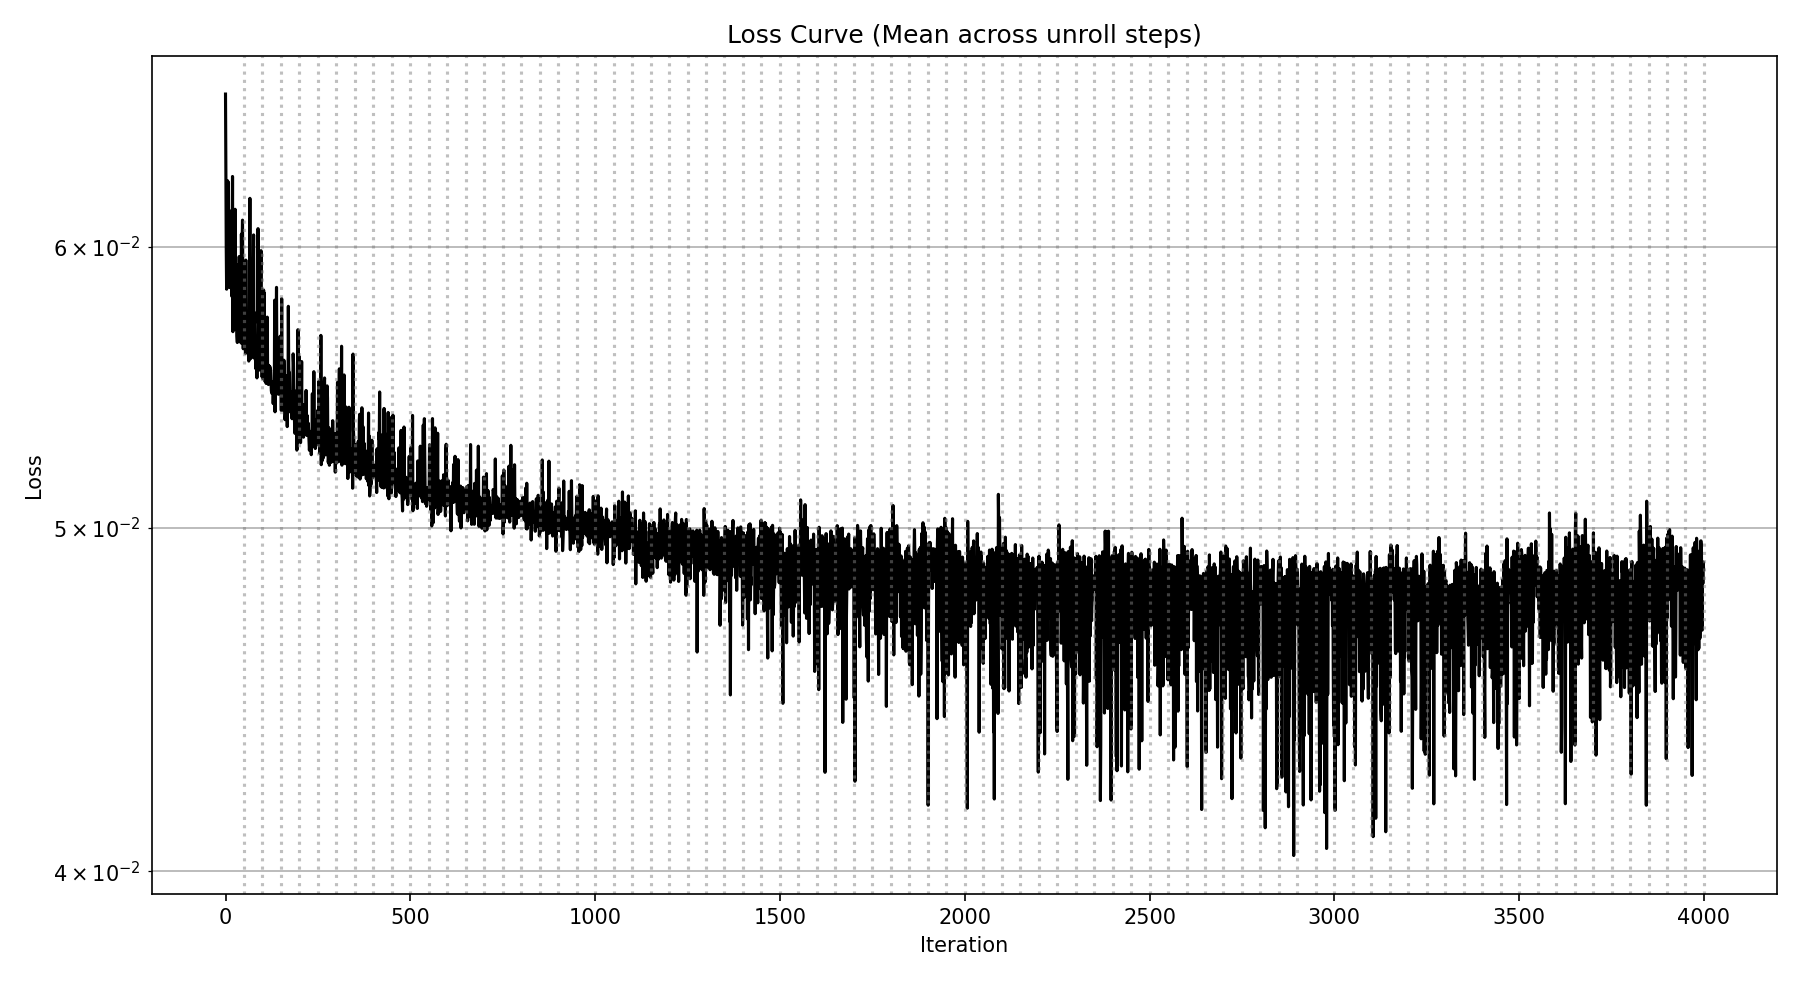

In [58]:
fig, axis = plt.subplots(1, 1, figsize=(12,6*1.09), sharex = True, sharey = False, squeeze = False)

axis[0,0].semilogy(net['l2'], c = 'black')
axis[0,0].set_title('Loss Curve (Mean across unroll steps)')
axis[0,0].grid(which = 'both', axis = 'y')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
for i in range(lrSteps + 1):
    if lrStep * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(lrStep * (i+1), ls = ':', alpha = 0.5, c = 'grey')
fig.tight_layout()

In [44]:
# processedLosses = [np.mean(l, axis = 1).tolist() for l in losses]
processedLosses = net['l2']
longestUnroll = losses[-1].shape[0]
unrollLengths = np.arange(longestUnroll) + 1
filtered = []

for i in unrollLengths:
    nStepLoss = [l[i - 1] for l in processedLosses if len(l) >= i]
    filtered.append(nStepLoss)
    
fig, axis = plt.subplots(2, 1, figsize=(12,6*1.09), sharex = True, sharey = False, squeeze = False)

axis[0,0].semilogy(l2, c = 'black')
axis[1,0].semilogy(l2, ls = '-', c = 'black', alpha = 0.5,lw = 2)
for i in range(lrSteps + 1):
    if lrStep * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(lrStep * (i+1), ls = ':', alpha = 0.5, c = 'grey')
#         axis[1,0].axvline(lrStep * (i+1), ls = '--', alpha = 0.25, c = 'grey')
    
for i in range(unrollSteps + 1):
    if unrollIncrement * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
        axis[1,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
    
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin = 1, vmax = longestUnroll + 1)    
for i in unrollLengths:
    axis[1,0].semilogy(np.arange(epochs * iterationsPerEpoch - 1 - len(filtered[i-1]), epochs * iterationsPerEpoch - 1), filtered[i-1], c = cmap(norm(i)), lw = 2)
    
axis[0,0].set_title('Loss Curve (Mean across unroll steps)')
axis[1,0].set_title('Loss Curves per unroll step')
axis[0,0].grid(which = 'both', axis = 'y')
axis[1,0].grid(which = 'both', axis = 'y')
axis[1,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
axis[1,0].set_ylabel('Loss')
fig.tight_layout()

NameError: name 'losses' is not defined

In [33]:
import pandas as pd

In [39]:
# networks = []
# for layout in tqdm(layouts):
#     net = trainNetwork(layout, 4, 4, 'fourier', 'fourier')
#     networks.append(net)
#     print('Finished training network with basis %s @ %2d terms with layout [%s] -> loss: %4e' % (net['rbf_x'], net['n'], ' '.join(str(s) for s in net['layers']), net['l2'][-1]))

In [40]:
# print(net['l2'])

In [41]:
# evalResult = pd.DataFrame()

# for i, net in enumerate(networks):
# #     print(net['layers'])
#     curFrame = pd.DataFrame({
#         'layout': '[%s]' % ' '.join(str(s) for s in net['layers']),
#         'n': net['n'],
#         'm': net['m'],
#         'rbf_x': net['rbf_x'],
#         'rbf_y': net['rbf_y'],
#         'l2last': net['l2'][-1],
#         'l2min' : np.min(net['l2'][-1]),
#         'l2': [net['l2']],
#         'parameters': count_parameters(net['model']),
#         'width': net['layers'][0],
#         'depth': len(net['layers']) - 1
#     }, index = [0])
#     evalResult = pd.concat((evalResult, curFrame), ignore_index = True)
# #     break
# display(evalResult)
# evalResult.to_csv('collisionLayoutAblation.csv')
# # l2.shape

In [42]:
# g = sns.catplot(x = 'width', y = 'l2min', hue = 'depth', col ='rbf_x', data = evalResult, 
#                 kind = 'point', height = 4, 
# #                 hue_order = ['CConv','SplineConv','DMCF', 'Fourier', 'Fourier (even)', 'Chebyshev'],
#                 col_order = ['fourier'], sharey= 'row',
# #                 row_order = ['l2last'], 
#                 aspect = 1.5, errorbar = ('pi', 50), scale = 0.75, errwidth=0.5, capsize=0.125,)

# g.set_titles('{col_name}')
# g.despine(left=True)
# g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Physics Update Ablation Study')

# # for xax in g.axes:
# #     for ax in xax:
# #         ax.set_yscale('log')
# #         ax.grid(which = 'major', axis = 'y')


# # for xax in g.axes:
# for ax in g.axes[0,:]:
#     ax.set_yscale('log')
#     ax.grid(which = 'major', axis = 'y')
# # for ax in g.axes[1,:]:
# #     ax.set_yscale('log')
# #     ax.grid(which = 'major', axis = 'y')


In [100]:
processedData = copy.deepcopy(evalResult)
processedData['depth'] = processedData['depth'].astype(str)

<IPython.core.display.Javascript object>


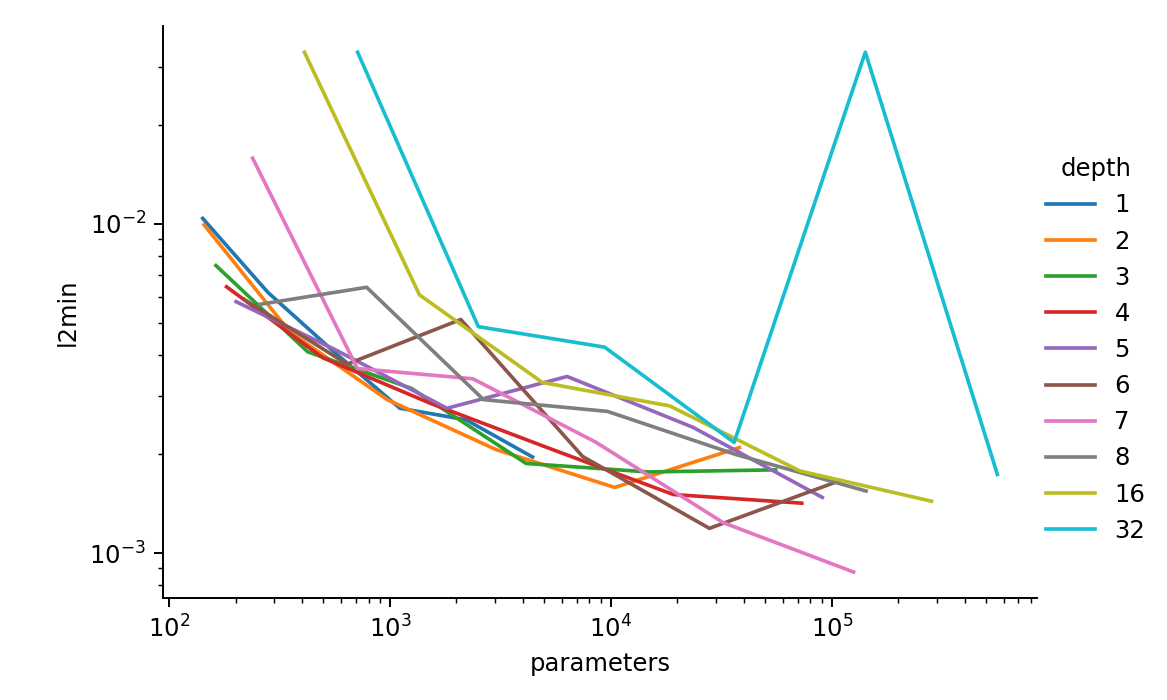

In [103]:
g = sns.relplot(x = 'parameters', y = 'l2min', hue = 'depth', data = processedData, 
                kind = 'line', height = 4, 
#                 hue_order = [1,2,3,4,5,6,7,8,16,32],
                facet_kws = {'sharey':False},
                aspect = 1.5)
# g.set_axis_labels('n','')
# g.axes[0,0].set_title('PSNR')
# g.axes[0,1].set_title('R2')
g.axes[0,0].set_yscale('log')
g.set_titles('{col_name}')
# g.despine(left=False)
# g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Physics Update Ablation Study')
g.axes[0,0].set_xscale('log')
# g.axes[0,0].set_xlim(2, 2**16)

In [187]:
random.seed(args.networkseed)
torch.manual_seed(args.networkseed)
torch.cuda.manual_seed(args.networkseed)
np.random.seed(args.networkseed)
boundaryFeatures = None

model = None
if args.network == 'default':
    model = RbfNet(
        fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, 
        coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, 
        rbf_x = rbf_x, rbf_y = rbf_y, 
        batchSize = 128, normalized = args.normalized)
if args.network == 'split':
    model = RbfSplitNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'interleaved':
    model = RbfInterleaveNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'input':
    model = RbfInputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)
if args.network == 'output':
    model = RbfOutputNet(fluidFeatures.shape[1], boundaryFeatures.shape[1] if boundaryFeatures is not None else 0, layers = layers, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = args.cutlassBatchSize, normalized = args.normalized)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr, weight_decay=args.weight_decay)
model = model.to(device)
model.train()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
if args.gpus == 1:
    print('Number of parameters', count_parameters(model))

Number of parameters 68636


In [188]:
from tqdm.notebook import tqdm


rbf_x = rbf_y = 'fourier'
print(rbf_x, rbf_y)

epochs = 1
batch_size = 4
iterationsPerEpoch = 4000
totalIterations = epochs * iterationsPerEpoch
initialUnroll = 1
unrollIncrement = 2000
unrollSteps = (epochs * iterationsPerEpoch) // unrollIncrement - 1
finalUnroll = initialUnroll + unrollSteps
initialLR = 1e-4
finalLR = 1e-2
lrStep = 50
lrSteps = int(np.ceil((totalIterations - lrStep) / lrStep))
gamma = np.power(finalLR / initialLR, 1/lrSteps)

optimizer = Adam(model.parameters(), lr=initialLR, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

print('Training network for %2d epochs @ %4d iterations -> %6d steps' % (epochs, iterationsPerEpoch, epochs * iterationsPerEpoch))
print('initialLR: %.4e, finalLR: %.4e, lrStep: %4d, lrSteps %4d, gamma %g' %(initialLR, finalLR, lrStep, lrSteps, gamma))
print('initialUnroll: %2d, finalUnroll: %2d, unrollIncrement: %4d, unrollSteps %2d' %(initialUnroll, finalUnroll, unrollIncrement, (epochs * iterationsPerEpoch) // unrollIncrement - 1))

Training network for  1 epochs @ 10000 iterations ->  10000 steps
initialLR: 1.0000e-04, finalLR: 1.0000e-02, lrStep:   50, lrSteps  199, gamma 1.02341
initialUnroll:  1, finalUnroll:  5, unrollIncrement: 2000, unrollSteps  4


In [189]:
dataIter = iter(train_dataloader)
try:
    bdata = next(dataIter)
except:
    dataIter = iter(train_dataloader)
    bdata = next(dataIter)
    
train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler
dataIter = iter(train_dataloader)
print(bdata)
device

[374, 5346, 5506, 766]


device(type='cuda')

In [190]:
losses = []
l2 = []

batch = [10,20,30,40]
batch = [10]
unrollSteps = 1   

for i in (t := tqdm(range(iterationsPerEpoch * epochs))):
#     try:
#         batch = next(dataIter)
#     except:
#         dataIter = iter(train_dataloader)
#         batch = next(dataIter)
#     batch = [0,dataCache.shape[0]//4,dataCache.shape[0]//2,dataCache.shape[0]-1]
    batchLoss = processBatchCached(batch, unrollSteps, dataCache, attributes, model, optimizer, train_ds)
    
    losses.append(batchLoss)
    l2.append(np.mean(batchLoss))
    
    t.set_description('Training it = %5d [%2d], batch: [%s] x %2d, lr: %.4e, batchLoss: %.5e, rollingLoss: %.5e, currentLoss: [%s]' % 
                      (i % iterationsPerEpoch, 
                       i // iterationsPerEpoch,
                       ' '.join(['%04d' % b for b in batch]), 
                       unrollSteps,
                       optimizer.param_groups[0]['lr'],
                       np.mean(batchLoss), 
                       np.mean(l2[-100:] if len(l2) > 100 else l2),
                       ' '.join(['%.4e' % v for v in np.mean(batchLoss, axis = 0)])
                      ))
    if i % lrStep == 0 and i > 0:
        scheduler.step()
#     if i % unrollIncrement == 0 and i > 0:
#         unrollSteps = unrollSteps + 1
#         lr = lr * 0.5
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = 0.5 * param_group['lr']
    
#     break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [191]:
processedLosses = [np.mean(l, axis = 1).tolist() for l in losses]
longestUnroll = losses[-1].shape[0]
unrollLengths = np.arange(longestUnroll) + 1
filtered = []

for i in unrollLengths:
    nStepLoss = [l[i - 1] for l in processedLosses if len(l) >= i]
    filtered.append(nStepLoss)
    
fig, axis = plt.subplots(2, 1, figsize=(12,6*1.09), sharex = True, sharey = False, squeeze = False)

axis[0,0].semilogy(l2, c = 'black')
axis[1,0].semilogy(l2, ls = '-', c = 'black', alpha = 0.5,lw = 2)
for i in range(lrSteps + 1):
    if lrStep * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(lrStep * (i+1), ls = ':', alpha = 0.5, c = 'grey')
#         axis[1,0].axvline(lrStep * (i+1), ls = '--', alpha = 0.25, c = 'grey')
    
for i in range(unrollSteps + 1):
    if unrollIncrement * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
        axis[1,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
    
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin = 1, vmax = longestUnroll + 1)    
for i in unrollLengths:
    axis[1,0].semilogy(np.arange(epochs * iterationsPerEpoch - 1 - len(filtered[i-1]), epochs * iterationsPerEpoch - 1), filtered[i-1], c = cmap(norm(i)), lw = 2)
    
axis[0,0].set_title('Loss Curve (Mean across unroll steps)')
axis[1,0].set_title('Loss Curves per unroll step')
axis[0,0].grid(which = 'both', axis = 'y')
axis[1,0].grid(which = 'both', axis = 'y')
axis[1,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
axis[1,0].set_ylabel('Loss')
fig.tight_layout()

<IPython.core.display.Javascript object>


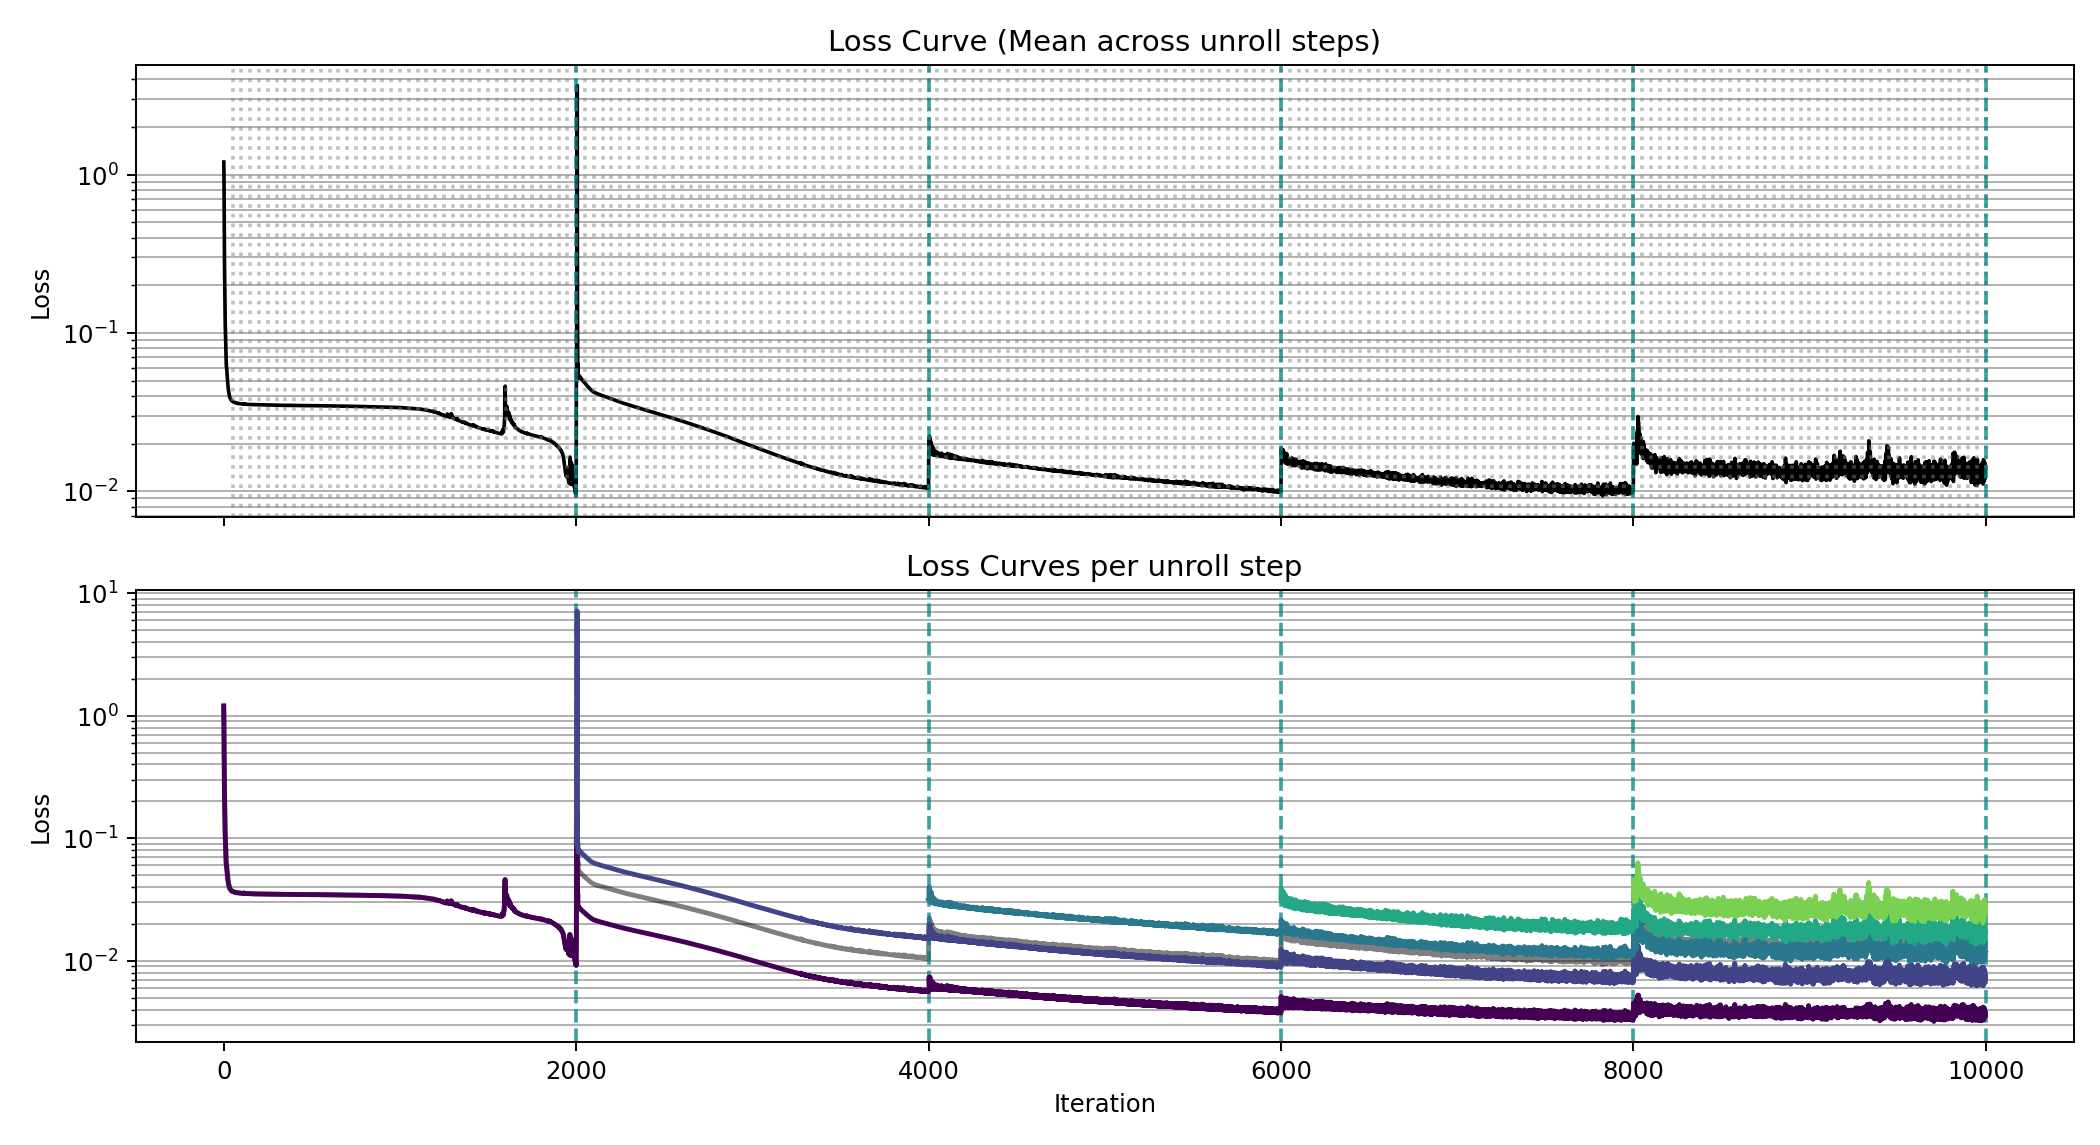

In [192]:
fig, axis = plt.subplots(2, 1, figsize=(12,6*1.09), sharex = True, sharey = False, squeeze = False)

axis[0,0].semilogy(l2, c = 'black')
axis[1,0].semilogy(l2, ls = '-', c = 'black', alpha = 0.5,lw = 2)
for i in range(lrSteps + 1):
    if lrStep * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(lrStep * (i+1), ls = ':', alpha = 0.5, c = 'grey')
#         axis[1,0].axvline(lrStep * (i+1), ls = '--', alpha = 0.25, c = 'grey')
    
for i in range(unrollSteps + 1):
    if unrollIncrement * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
        axis[1,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
    
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin = 1, vmax = longestUnroll + 1)    
for i in unrollLengths:
    axis[1,0].semilogy(np.arange(epochs * iterationsPerEpoch - 1 - len(filtered[i-1]), epochs * iterationsPerEpoch - 1), filtered[i-1], c = cmap(norm(i)), lw = 2)
    
axis[0,0].set_title('Loss Curve (Mean across unroll steps)')
axis[1,0].set_title('Loss Curves per unroll step')
axis[0,0].grid(which = 'both', axis = 'y')
axis[1,0].grid(which = 'both', axis = 'y')
axis[1,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
axis[1,0].set_ylabel('Loss')
fig.tight_layout()

<IPython.core.display.Javascript object>


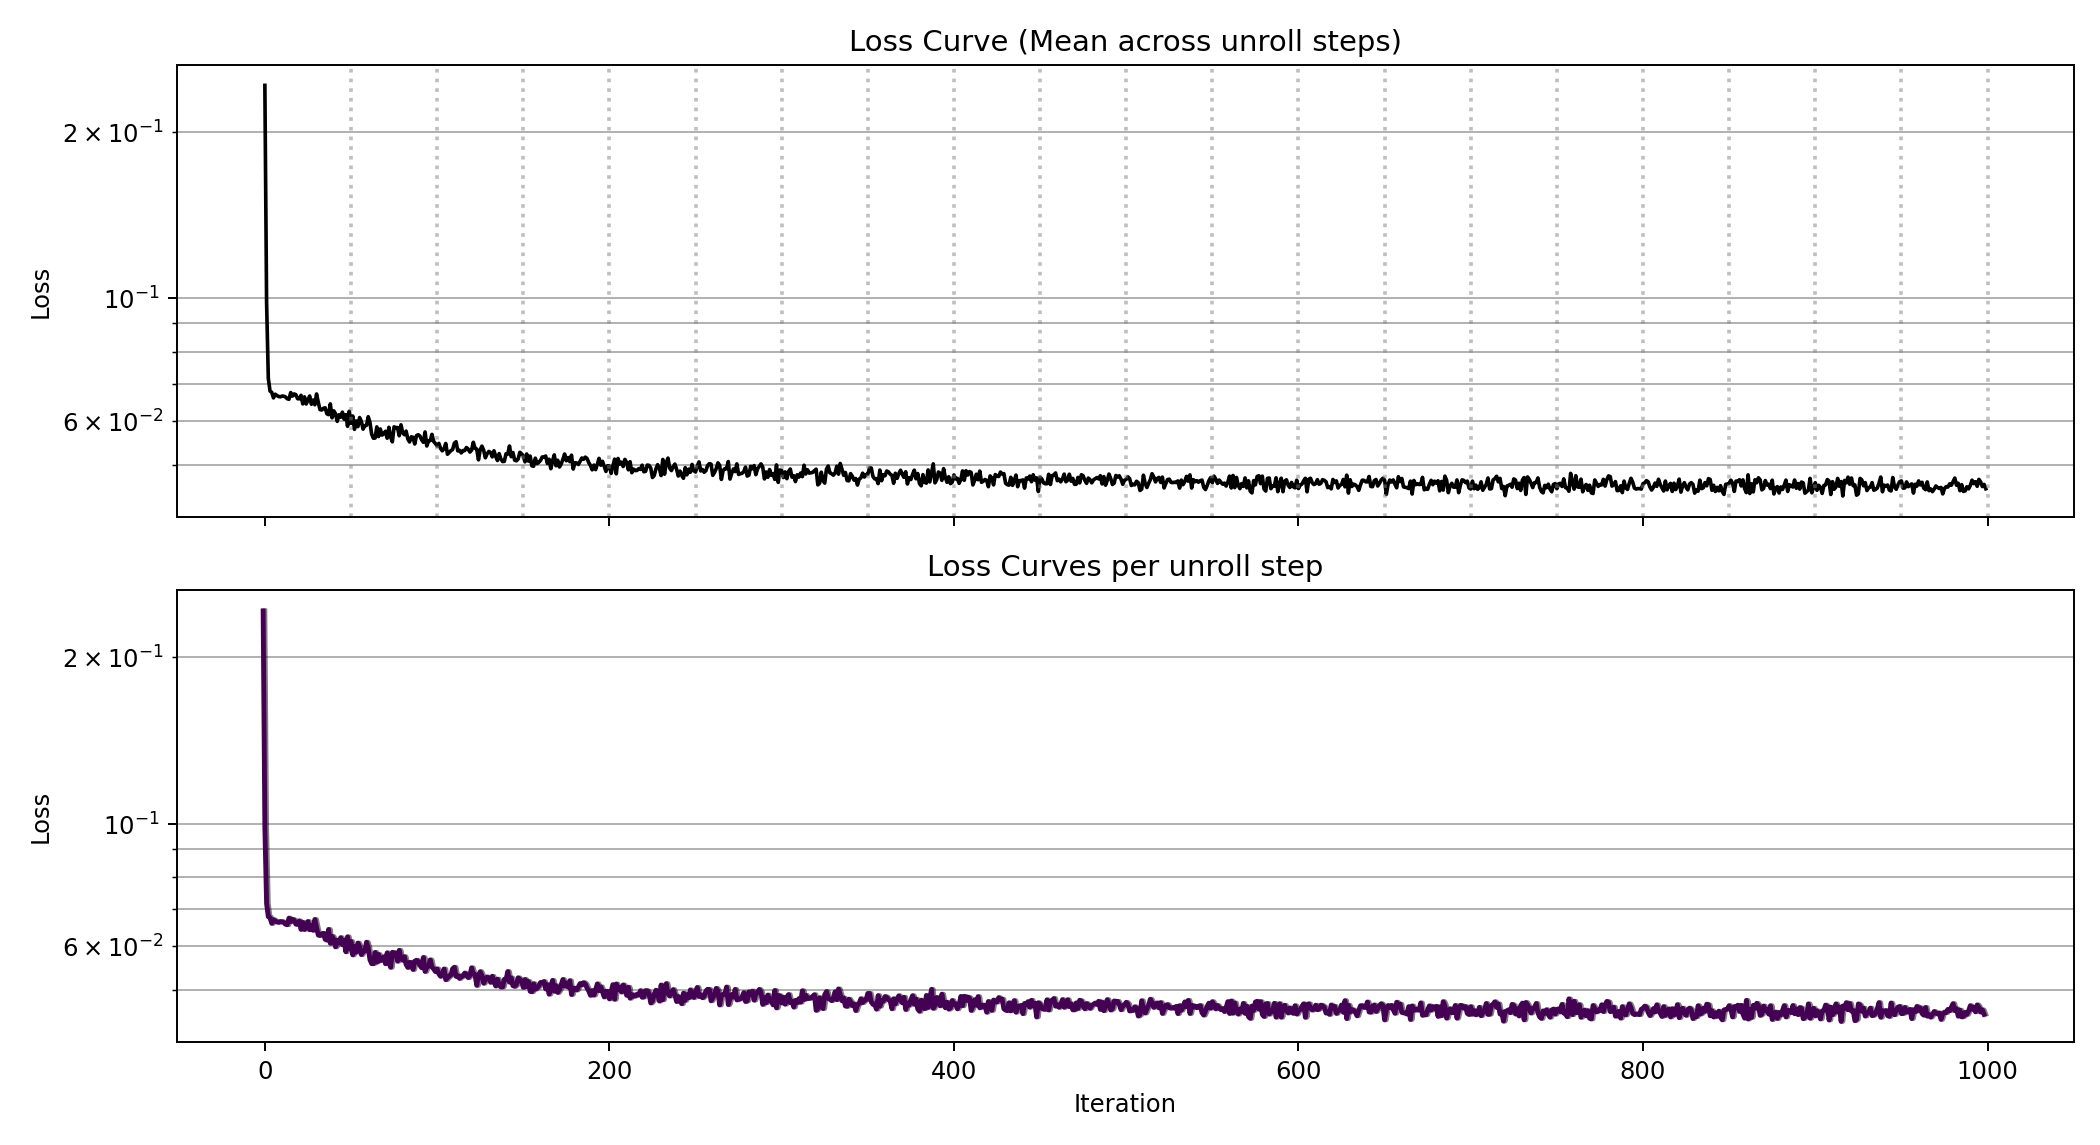

In [95]:
fig, axis = plt.subplots(2, 1, figsize=(12,6*1.09), sharex = True, sharey = False, squeeze = False)

axis[0,0].semilogy(l2, c = 'black')
axis[1,0].semilogy(l2, ls = '-', c = 'black', alpha = 0.5,lw = 2)
for i in range(lrSteps + 1):
    if lrStep * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(lrStep * (i+1), ls = ':', alpha = 0.5, c = 'grey')
#         axis[1,0].axvline(lrStep * (i+1), ls = '--', alpha = 0.25, c = 'grey')
    
for i in range(unrollSteps + 1):
    if unrollIncrement * (i+1) <= epochs * iterationsPerEpoch:
        axis[0,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
        axis[1,0].axvline(unrollIncrement * (i+1), ls = '--', alpha = 0.75, c = 'teal')
    
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin = 1, vmax = longestUnroll + 1)    
for i in unrollLengths:
    axis[1,0].semilogy(np.arange(epochs * iterationsPerEpoch - 1 - len(filtered[i-1]), epochs * iterationsPerEpoch - 1), filtered[i-1], c = cmap(norm(i)), lw = 2)
    
axis[0,0].set_title('Loss Curve (Mean across unroll steps)')
axis[1,0].set_title('Loss Curves per unroll step')
axis[0,0].grid(which = 'both', axis = 'y')
axis[1,0].grid(which = 'both', axis = 'y')
axis[1,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
axis[1,0].set_ylabel('Loss')
fig.tight_layout()

In [47]:
def evalBatch(bdata, unrollSteps : int, dataCache : torch.Tensor, attributes, model, dataSet):
#     dataRows = torch.zeros([len(bdata), unrollSteps, dataCache.shape[1], dataCache.shape[2]])
    dataRows = []
    for ib, b in enumerate(bdata):
        file, frame, unroll = dataSet[b]
        batchData = []
        for iu, u in enumerate(range(unrollSteps)):
            currRow = dataCache[file][frame + u,:].unsqueeze(0)
#             print('Current row shape: ', currRow.shape)
            batchData.append(currRow)
        stacked = torch.vstack(batchData)
#         print('Stacked shape:', stacked.shape)
        dataRows.append(stacked)
    dataRows = torch.stack(dataRows)
#     print('data rows shape', dataRows.shape)
    
#     dataRows = torch.zeros([len(bdata), unrollSteps, dataCache.shape[1], dataCache.shape[2]])

#     for ib, b in enumerate(bdata):
#         for iu, u in enumerate(range(unrollSteps)):
#             currRow = dataCache[b + iu,:,:]
#             dataRows[ib, iu, :, :] = currRow
    dataRows = dataRows.to(device)
    fluidBatches = torch.hstack([torch.ones(dataRows.shape[2]) * i for i in range(len(bdata))]).to(device)
    
    fluidPositions = torch.clone(torch.vstack([r[0,:,0:2] for r in dataRows]))
    fluidVelocity = torch.clone(torch.vstack([r[0,:,2:4] for r in dataRows]))
    fluidGravity = torch.clone(torch.vstack([r[0,:,4:6] for r in dataRows]))
    fluidFeatures = torch.vstack([r[0,:,6:10] for r in dataRows])

    boundaryPositions = None
    boundaryFeatures = None
    boundaryBatches = None

    unrollLosses = []
    states = []
#     optimizer.zero_grad()
    for iu, u in enumerate(tqdm(range(unrollSteps), leave = False)):    
        gtFluidPositions = torch.vstack([r[iu,:,10:12] for r in dataRows])

        intermediateVelocity = fluidVelocity + frameDistance * attributes['dt'] * fluidGravity
        intermediatePositions = fluidPositions + frameDistance * attributes['dt'] * intermediateVelocity

        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], intermediateVelocity, fluidFeatures[:,3:]))
        predictedUpdate = model(fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, fluidBatches, boundaryBatches)
        
        
        loss = torch.linalg.norm(intermediatePositions + predictedUpdate[:,:2] * attributes['dt'] - gtFluidPositions, dim = 1) / attributes['dt']
        states.append((torch.clone(fluidPositions).detach().cpu(), torch.clone(fluidVelocity).detach().cpu(), torch.clone(fluidGravity).detach().cpu(), torch.clone(predictedUpdate).detach().cpu(), torch.clone(gtFluidPositions).detach().cpu(), torch.clone(loss).detach().cpu()))
        lossTerm = torch.mean(loss.reshape(len(bdata), dataRows.shape[2]), dim = 1)
#         print('loss', loss)
#         print('loss.reshaped', loss.reshape(len(bdata), dataCache.shape[1]))
#         print('lossTerm', lossTerm)
        unrollLosses.append(lossTerm)

        if iu != unrollSteps - 1:
            updatedPositions = intermediatePositions + predictedUpdate[:,:2] * attributes['dt']
            fluidVelocity = (updatedPositions - fluidPositions) / attributes['dt']
            fluidPositions = updatedPositions
            difference = fluidPositions
            distance = torch.linalg.norm(difference,axis=1) + 1e-7
            difference = difference / distance[:, None]
            fluidGravity = -0.5 * 10**2 * difference * (distance)[:,None]**2

#     print(unrollLosses)
#     print(torch.vstack(unrollLosses))
#     print(torch.mean(torch.vstack(unrollLosses)))
    stackedLosses = torch.vstack(unrollLosses)
    overallLoss = torch.mean(stackedLosses)
#     overallLoss.backward()
#     optimizer.step()
    return states, stackedLosses.detach().cpu().numpy()

In [49]:
# net = [n for n in networks if n['layers'] == [32]*7 + [2]][0]
print(net)

{'model': RbfNet(
  (convs): ModuleList(
    (0): RbfConv(4, 32, dim=2)
    (1): RbfConv(64, 32, dim=2)
    (2): RbfConv(32, 32, dim=2)
    (3): RbfConv(32, 32, dim=2)
    (4): RbfConv(32, 32, dim=2)
    (5): RbfConv(32, 32, dim=2)
    (6): RbfConv(32, 2, dim=2)
  )
  (fcs): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
), 'n': 4, 'm': 4, 'layers': [32, 32, 32, 32, 32, 32, 2], 'rbf_x': 'fourier', 'rbf_y': 'fourier', 'processesLosses': [[0.06686464697122574], [0.0676928237080574], [0.06623954325914383], [0.06610282510519028], [0.06536904722452164], [0.06484720855951309], [0.06409990042448044], [0.063948392

In [50]:
evaluationDataset = test_ds
evaluationBatch = 20
evaluationDataset = train_ds
evaluationBatch = 10
evaluationSteps = 96
with torch.no_grad():
    predictionSteps, loss = evalBatch([evaluationBatch], evaluationSteps, dataCache, attributes, net['model'], evaluationDataset)

  0%|          | 0/96 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


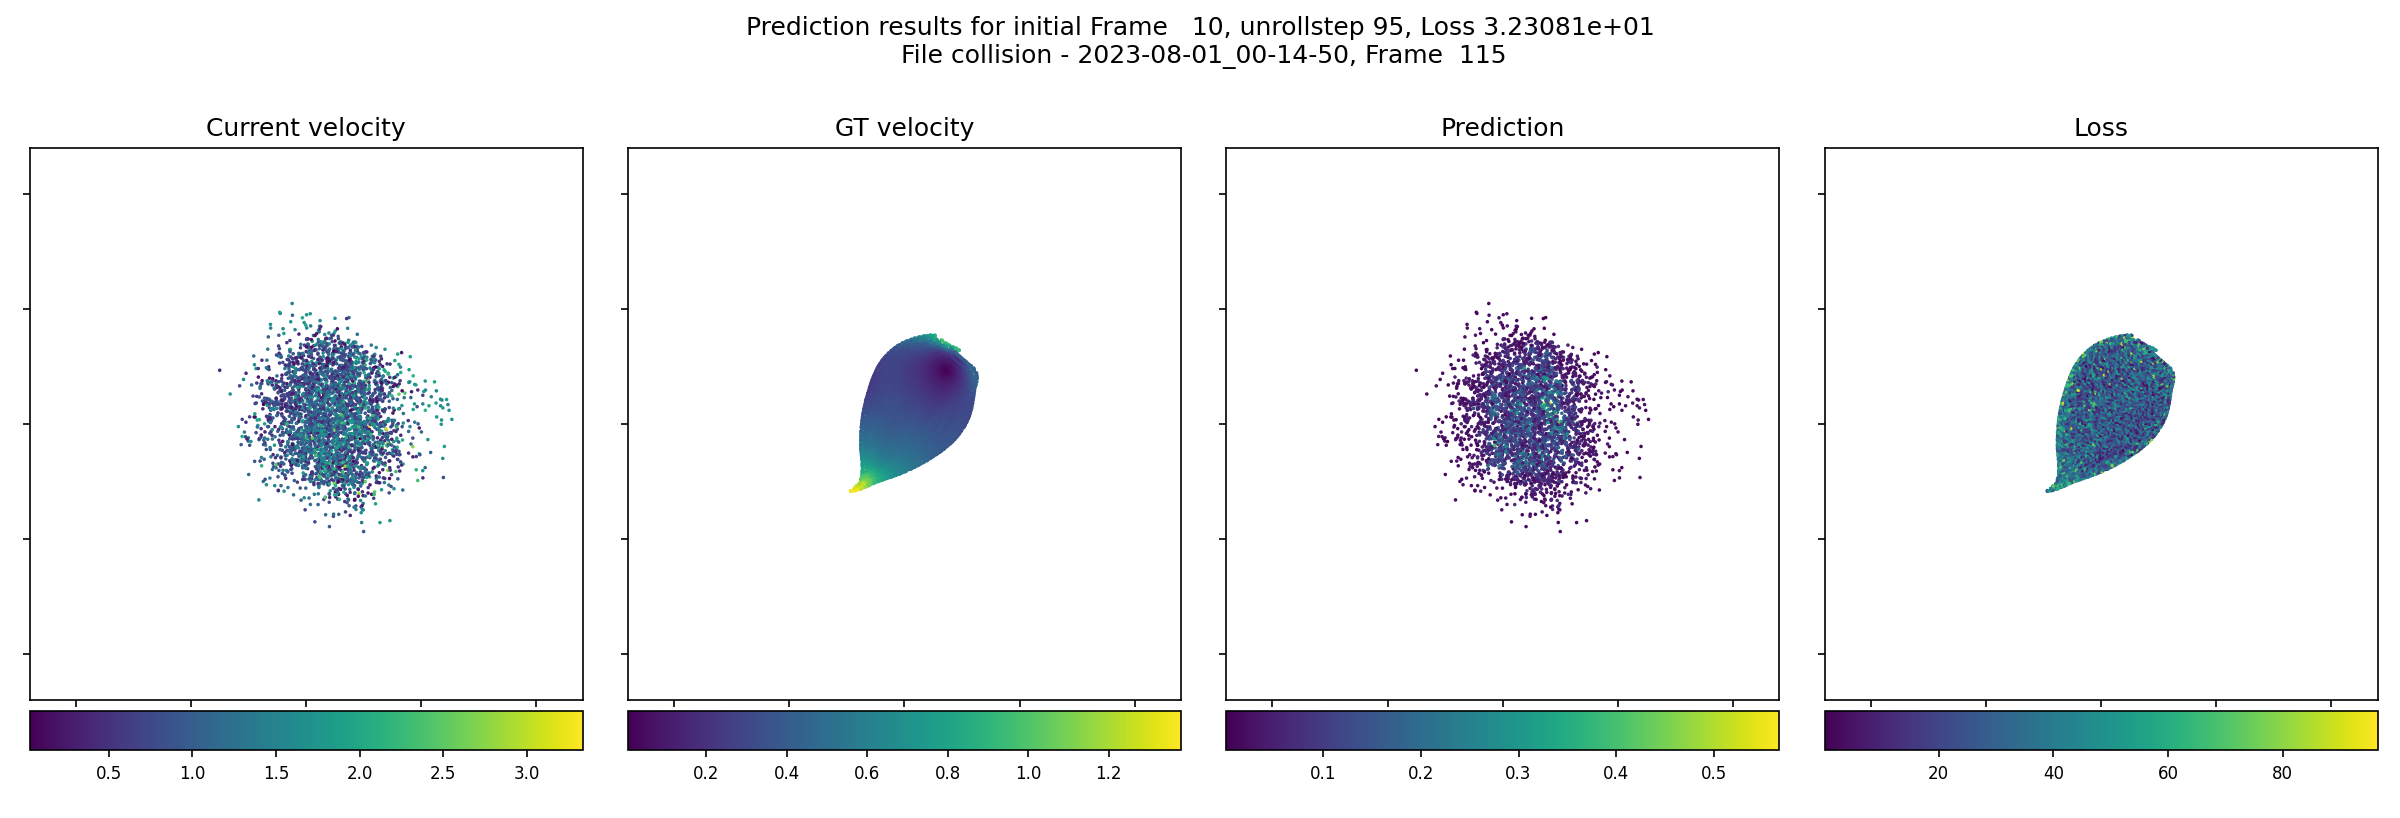

interactive(children=(IntSlider(value=0, description='frame', max=95), Output()), _dom_classes=('widget-intera…

<function __main__.plotStep(frame)>

In [51]:
fig, axis = plt.subplots(1, 4, figsize=(16,5*1.09), sharex = False, sharey = False, squeeze = False)

currPositions, currVelocity, currGravity, currUpdate, currGT, currLoss = predictionSteps[0]

x = currPositions[:,0].detach().cpu().numpy()
y = currPositions[:,1].detach().cpu().numpy()

v = torch.linalg.norm(currVelocity, dim=1).detach().cpu().numpy()
vGT = torch.linalg.norm(currGT - currPositions, dim=1).detach().cpu().numpy()
vPred = torch.linalg.norm(currUpdate, dim=1).detach().cpu().numpy()

def scatterToAxis(fig, axis, x, y, v, title):
    axis.set_title(title)
    GTsc = axis.scatter(x,y,c = v, s= 0.5)
    axis.axis('equal')
    axis.set_xlim(-1.2,1.2)
    axis.set_ylim(-1.2,1.2)
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
    GTcbar.ax.tick_params(labelsize=8) 
    return GTsc, GTcbar

velScatter, velCbar = scatterToAxis(fig, axis[0,0], x, y, v, 'Current velocity')
velGTScatter, velGTCbar = scatterToAxis(fig, axis[0,1], x, y, vGT, 'GT velocity')
velPredScatter, velPredCbar = scatterToAxis(fig, axis[0,2], x, y, vPred, 'Prediction')
lossScatter, lossCbar = scatterToAxis(fig, axis[0,3], x, y, currLoss, 'Loss')

fig.suptitle('Prediction results for initial Frame %4d, unrollstep %2d, Loss %.5e\n File %s, Frame %4d' % (evaluationBatch, 0, np.mean(loss[0]), evaluationDataset[evaluationBatch][0].split('/')[-1].split('.')[0], evaluationDataset[evaluationBatch][1]) )

fig.tight_layout()

def plotStep(frame):    
    currPositions, currVelocity, currGravity, currUpdate, currGT, currLoss = predictionSteps[frame]
    fig.suptitle('Prediction results for initial Frame %4d, unrollstep %2d, Loss %.5e\n File %s, Frame %4d' % (evaluationBatch, frame, np.mean(loss[frame]), evaluationDataset[evaluationBatch][0].split('/')[-1].split('.')[0], evaluationDataset[evaluationBatch][1] + frame * args.frameDistance) )

    x = currPositions[:,0].detach().cpu().numpy()
    y = currPositions[:,1].detach().cpu().numpy()

    v = torch.linalg.norm(currVelocity, dim=1).detach().cpu().numpy()
    vGT = torch.linalg.norm(currGT - currPositions, dim=1).detach().cpu().numpy()
    vPred = torch.linalg.norm(currUpdate, dim=1).detach().cpu().numpy()
    
    if frame > 0:        
        prevPositions, prevVelocity, prevGravity, prevUpdate, prevGT, currLoss = predictionSteps[frame - 1]
        velGTScatter.set_offsets(prevGT.detach().cpu().numpy())
#         gtPositions = prevGT
        vGT = torch.linalg.norm(currGT - prevGT, dim=1).detach().cpu().numpy() / attributes['dt']
        velGTScatter.set_array(vGT)
        velGTCbar.mappable.set_clim(vmin=np.min(vGT), vmax=np.max(vGT))
        lossScatter.set_offsets(prevGT.detach().cpu().numpy())
    else:
        velGTScatter.set_offsets(currPositions.detach().cpu().numpy())
        velGTScatter.set_array(vGT)
        velGTCbar.mappable.set_clim(vmin=np.min(vGT), vmax=np.max(vGT))
        lossScatter.set_offsets(currPositions.detach().cpu().numpy())          
    
    velScatter.set_offsets(currPositions.detach().cpu().numpy())
    velPredScatter.set_offsets(currPositions.detach().cpu().numpy())
    
    velScatter.set_array(v)
    velPredScatter.set_array(vPred)
    lossScatter.set_array(currLoss)
    
    velCbar.mappable.set_clim(vmin=np.min(v), vmax=np.max(v))
    velPredCbar.mappable.set_clim(vmin=np.min(vPred), vmax=np.max(vPred))
    lossCbar.mappable.set_clim(vmin=np.min(currLoss.detach().cpu().numpy()), vmax=np.max(currLoss.detach().cpu().numpy()))
    fig.canvas.draw()
    fig.canvas.flush_events()
    
interact(plotStep, frame = widgets.IntSlider(value=0, min=0, max=evaluationSteps -1, step=1))

<IPython.core.display.Javascript object>


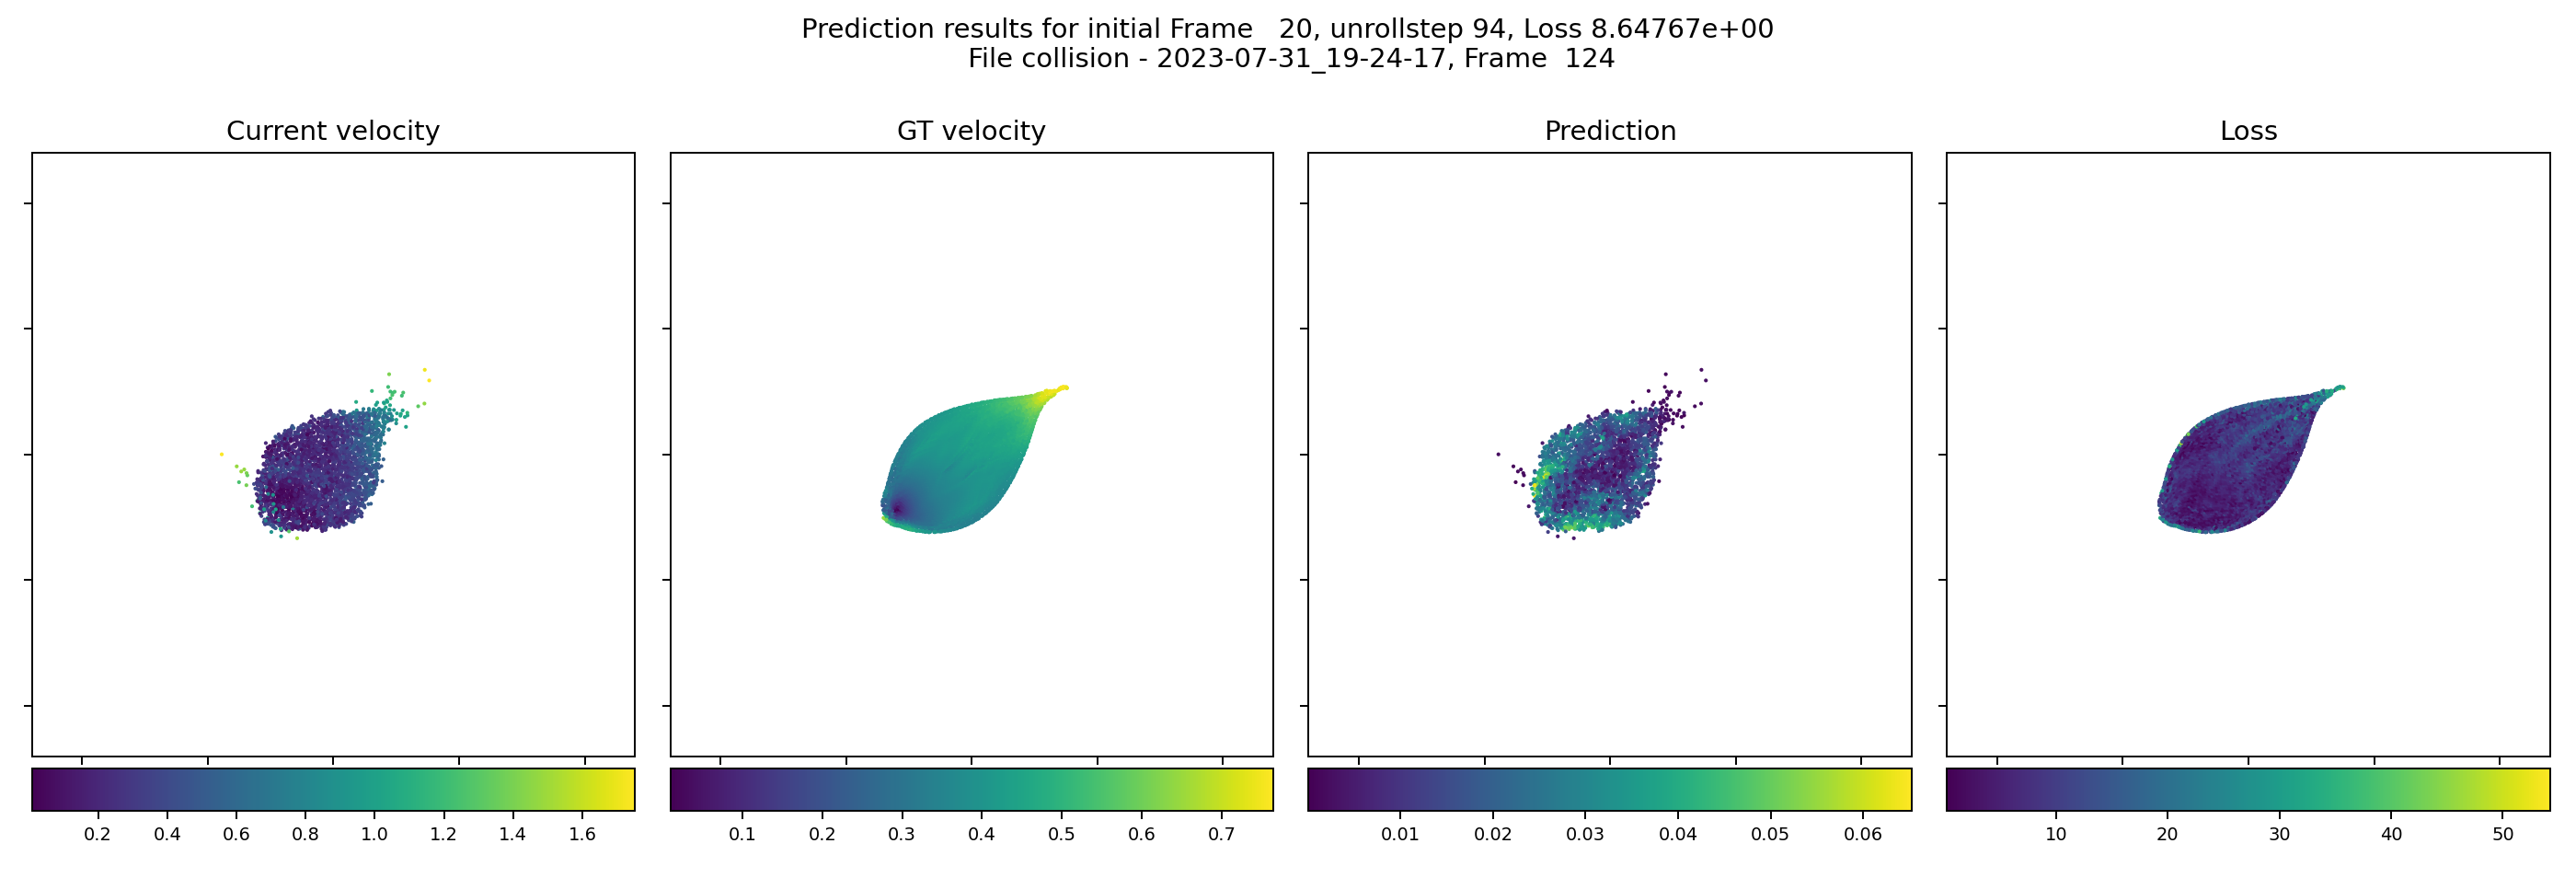

  0%|          | 0/95 [00:00<?, ?it/s]

In [31]:
label = 'collisionTest2'
imageFolder = '../images/%s/%s/' % (label, rbf_x)
#     print(imageFolder)
#     break

if not os.path.exists(imageFolder):
    os.makedirs(imageFolder)
#     for i in tqdm(range(0, frameCount, 8), leave = False):
#         plotNetwork(simulationFile, i)
fig, axis = plt.subplots(1, 4, figsize=(16,5*1.09), sharex = False, sharey = False, squeeze = False)

currPositions, currVelocity, currGravity, currUpdate, currGT, currLoss = predictionSteps[0]

x = currPositions[:,0].detach().cpu().numpy()
y = currPositions[:,1].detach().cpu().numpy()

v = torch.linalg.norm(currVelocity, dim=1).detach().cpu().numpy()
vGT = torch.linalg.norm(currGT - currPositions, dim=1).detach().cpu().numpy()
vPred = torch.linalg.norm(currUpdate, dim=1).detach().cpu().numpy()

def scatterToAxis(fig, axis, x, y, v, title):
    axis.set_title(title)
    GTsc = axis.scatter(x,y,c = v, s= 0.5)
    axis.axis('equal')
    axis.set_xlim(-1.2,1.2)
    axis.set_ylim(-1.2,1.2)
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
    GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
    GTcbar.ax.tick_params(labelsize=8) 
    return GTsc, GTcbar

velScatter, velCbar = scatterToAxis(fig, axis[0,0], x, y, v, 'Current velocity')
velGTScatter, velGTCbar = scatterToAxis(fig, axis[0,1], x, y, vGT, 'GT velocity')
velPredScatter, velPredCbar = scatterToAxis(fig, axis[0,2], x, y, vPred, 'Prediction')
lossScatter, lossCbar = scatterToAxis(fig, axis[0,3], x, y, currLoss, 'Loss')

fig.suptitle('Prediction results for initial Frame %4d, unrollstep %2d, Loss %.5e\n File %s, Frame %4d' % (evaluationBatch, 0, np.mean(loss[0]), evaluationDataset[evaluationBatch][0].split('/')[-1].split('.')[0], evaluationDataset[evaluationBatch][1]) )

fig.tight_layout()

for i in tqdm(range(evaluationSteps - 1)):
    plotStep(i)
    imagePath = '../images/%s/%s/%04d.png' % (label, rbf_x, i)
    plt.savefig(imagePath, dpi = 200)